In [1]:
from xgboost import plot_importance
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

In [3]:
# Specify the path to the CSV file
url = "https://raw.githubusercontent.com/Timson1235/energy-timeseries-project/803c1688c8fa5a74c19e7a13b69541e42902bffb/Data/merged_cleaned.csv"


# Load the data
load_data = pd.read_csv(url)

# Rename the specific column to "load"
load_data.rename(columns={"Gesamt (Netzlast) [MWh] Berechnete Auflösungen": "load"}, inplace=True)

# Convert the "Date" column to datetime format
load_data['Date'] = pd.to_datetime(load_data['Date'])

# Filter the DataFrame to include only the "Date" and "load" columns
filtered_data = load_data[['Date', 'load']]

# Display the filtered DataFrame
print(filtered_data.head())

                 Date      load
0 2018-11-01 00:00:00  48879.50
1 2018-11-01 01:00:00  47312.50
2 2018-11-01 02:00:00  46093.75
3 2018-11-01 03:00:00  46710.50
4 2018-11-01 04:00:00  47624.25


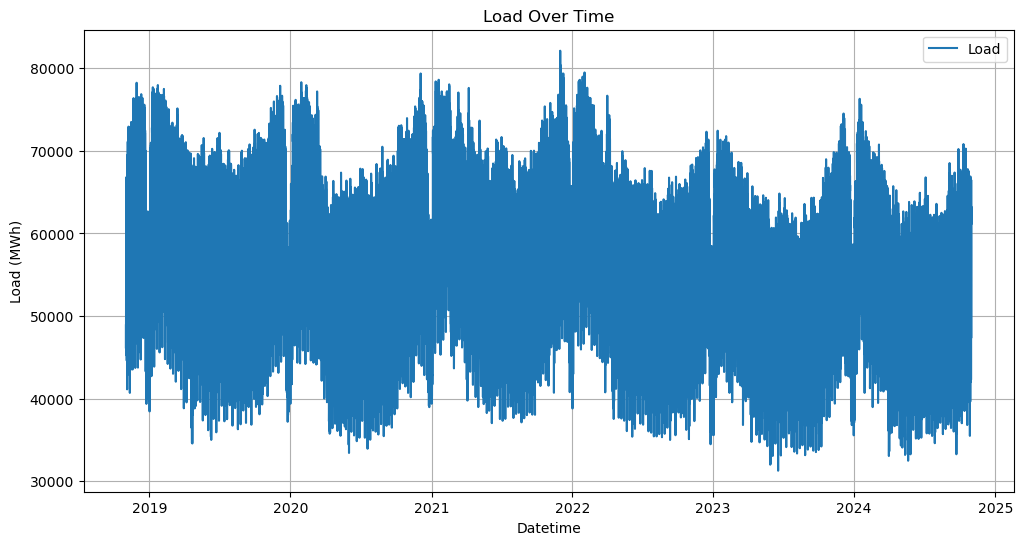

In [5]:
# Plot the load against datetime for visualization
plt.figure(figsize=(12, 6))
plt.plot(filtered_data['Date'], filtered_data['load'], label='Load')
plt.xlabel('Datetime')
plt.ylabel('Load (MWh)')
plt.title('Load Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# Extract the start time from the datetime column
filtered_data['Date'] = filtered_data['Date'].apply(lambda x: x.split(' - ')[0] if isinstance(x, str) else x)
# Set the 'datetime' column as the index
filtered_data.set_index('Date', inplace=True)


C:\Users\ZainHafizMuhammad\AppData\Local\Temp\ipykernel_22548\2079366551.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Date'] = filtered_data['Date'].apply(lambda x: x.split(' - ')[0] if isinstance(x, str) else x)


In [9]:
# Split data into training and testing sets
split_date = '2024-08-01'
train_data = filtered_data.loc[filtered_data.index < split_date].copy()
test_data = filtered_data.loc[filtered_data.index >= split_date].copy()


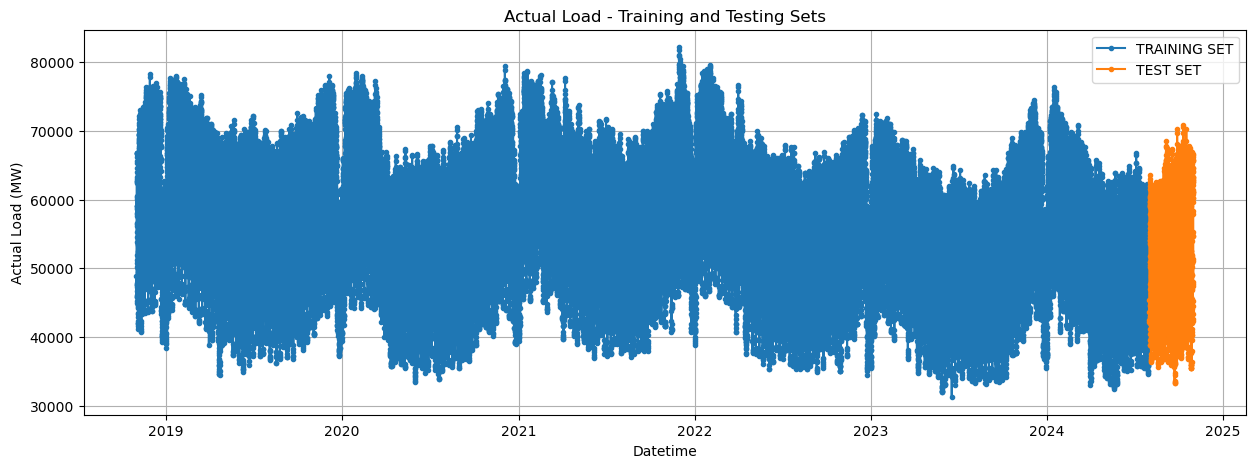

In [11]:
# Plot the training and testing sets
plt.figure(figsize=(15, 5))
plt.plot(train_data.index, train_data['load'], label='TRAINING SET', linestyle='-', marker='.')
plt.plot(test_data.index, test_data['load'], label='TEST SET', linestyle='-', marker='.')
plt.title('Actual Load - Training and Testing Sets')
plt.xlabel('Datetime')
plt.ylabel('Actual Load (MW)')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# Define the function to create features
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    
    X = df[['hour', 'dayofweek', 'quarter', 'month', 'year',
            'dayofyear', 'dayofmonth', 'weekofyear']]
    
    if label:
        y = df[label]
        return X, y
    return X

# Define the target label
target_label = 'load'

# Create features and labels for training and testing sets
X_train, y_train = create_features(train_data, label=target_label)
X_test, y_test = create_features(test_data, label=target_label)

In [15]:
# Initialize the XGBoost Regressor
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, objective='reg:squarederror')

# Fit the model with early stopping
reg.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=True
)

[0]	validation_0-rmse:7476.58444	validation_1-rmse:7112.60988
[1]	validation_0-rmse:5873.94243	validation_1-rmse:5344.99179
[2]	validation_0-rmse:4814.91030	validation_1-rmse:4222.41689
[3]	validation_0-rmse:4140.30409	validation_1-rmse:3600.20543
[4]	validation_0-rmse:3627.82334	validation_1-rmse:3165.44509
[5]	validation_0-rmse:3315.93846	validation_1-rmse:2844.31245
[6]	validation_0-rmse:3074.39304	validation_1-rmse:2726.05915
[7]	validation_0-rmse:2926.77613	validation_1-rmse:2643.53744
[8]	validation_0-rmse:2799.10545	validation_1-rmse:2616.78831
[9]	validation_0-rmse:2596.07008	validation_1-rmse:2645.98655
[10]	validation_0-rmse:2528.99821	validation_1-rmse:2595.44578
[11]	validation_0-rmse:2457.64603	validation_1-rmse:2616.81804
[12]	validation_0-rmse:2364.81475	validation_1-rmse:2628.59181
[13]	validation_0-rmse:2294.77717	validation_1-rmse:2647.75775
[14]	validation_0-rmse:2265.95203	validation_1-rmse:2638.04242
[15]	validation_0-rmse:2230.43344	validation_1-rmse:2634.83786
[1

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

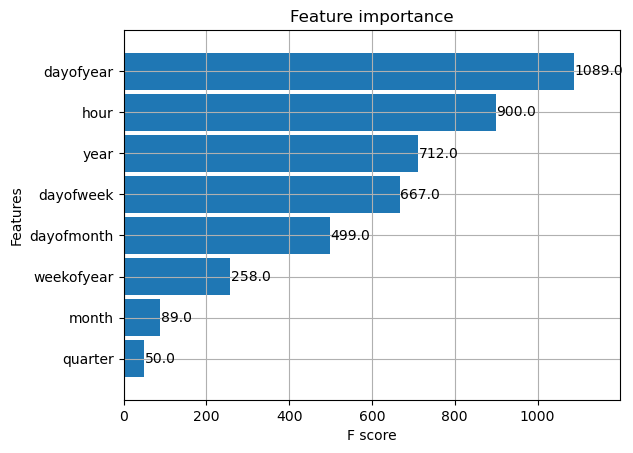

In [17]:
# Plot feature importance
_ = plot_importance(reg, height=0.9)
plt.show()


In [19]:
# Add predictions to the test dataset
test_data['load_prediction'] = reg.predict(X_test)

In [21]:
# Concatenate the training and test datasets
all_data = pd.concat([test_data, train_data], sort=False)

# Ensure the index is a DatetimeIndex and sorted
all_data.index = pd.to_datetime(all_data.index)
all_data = all_data.sort_index()


<Figure size 1500x500 with 0 Axes>

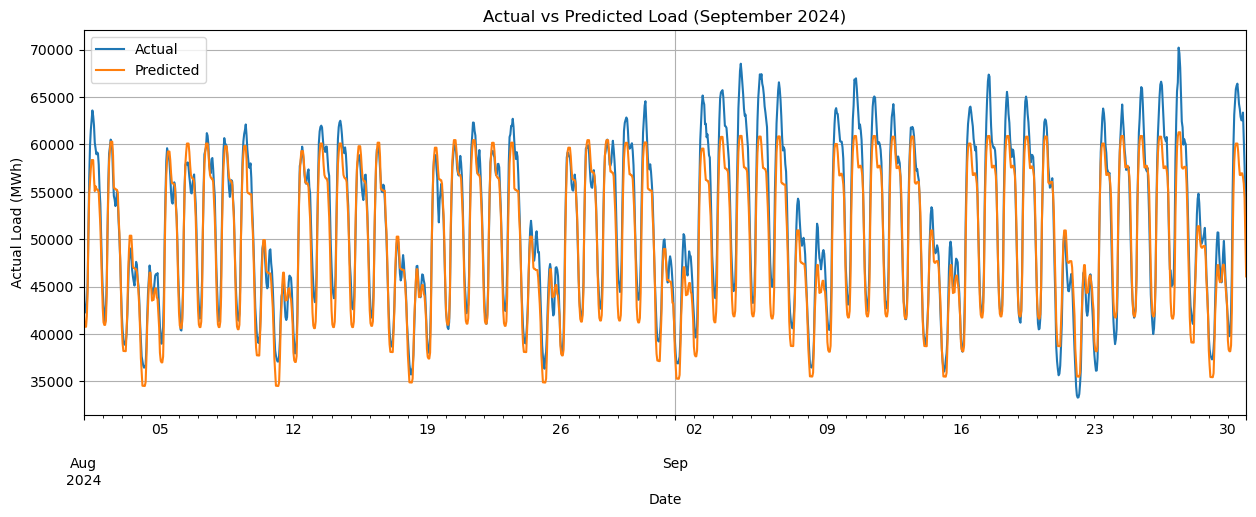

In [23]:
# Filter data for September 2024
september_2024_data = all_data.loc['2024-08-01':'2024-09-30']

# Plot actual vs predicted values for September 2024
plt.figure(figsize=(15, 5))
september_2024_data[['load', 'load_prediction']].plot(figsize=(15, 5), title="Actual vs Predicted Load (September 2024)")
plt.xlabel("Date")
plt.ylabel("Actual Load (MWh)")
plt.legend(["Actual", "Predicted"])
plt.grid(True)
plt.show()

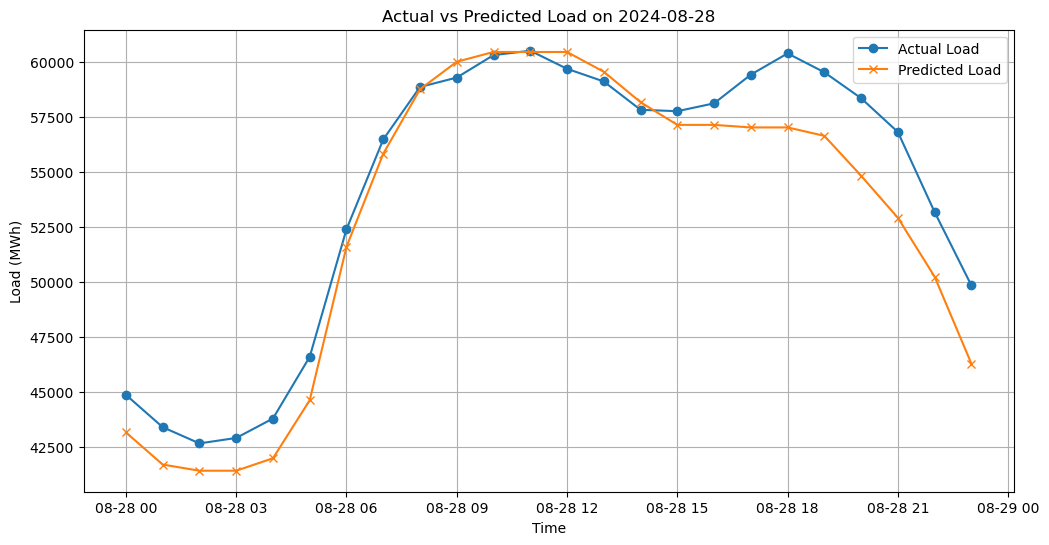

In [27]:
# For one specific date
def plot_day(data, date_str):
    day_data = data.loc[date_str]
    plt.figure(figsize=(12, 6))
    plt.plot(day_data.index, day_data['load'], label='Actual Load', marker='o')
    plt.plot(day_data.index, day_data['load_prediction'], label='Predicted Load', marker='x')
    plt.title(f"Actual vs Predicted Load on {date_str}")
    plt.xlabel("Time")
    plt.ylabel("Load (MWh)")
    plt.legend()
    plt.grid(True)
    plt.show()
plot_day(all_data, '2024-08-28')  # Plot for one day

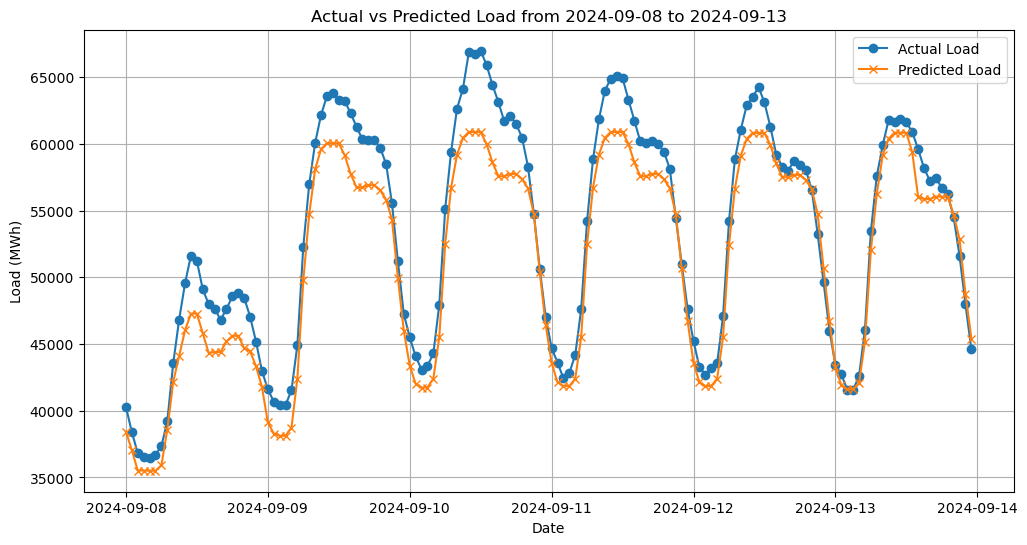

In [29]:
# For one specific week
def plot_week(data, start_date, end_date):
    week_data = data.loc[start_date:end_date]
    plt.figure(figsize=(12, 6))
    plt.plot(week_data.index, week_data['load'], label='Actual Load', marker='o')
    plt.plot(week_data.index, week_data['load_prediction'], label='Predicted Load', marker='x')
    plt.title(f"Actual vs Predicted Load from {start_date} to {end_date}")
    plt.xlabel("Date")
    plt.ylabel("Load (MWh)")
    plt.legend()
    plt.grid(True)
    plt.show()
plot_week(all_data, '2024-09-08', '2024-09-13')  # Plot for one week


In [33]:
# Calculate R^2 and RMSE
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, test_data['load_prediction'])
r2 = r2_score(y_test, test_data['load_prediction'])
rmse = np.sqrt(mean_squared_error(y_test, test_data['load_prediction']))
print(f"R^2: {r2}")
print(f"RMSE: {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

R^2: 0.9122873442088925
RMSE: 2571.328046459188
Mean Absolute Error (MAE): 1978.048219277727


In [43]:
#Up next?
#Add Lag variables
#Add holiday indicators.
#Add weather data source.